In [1]:
from models.resnet_model import get_resnet_model
import wandb
wandb.init() 
wandb.config.NUM_CLASSES = 3
from torchvision import transforms
from preprocessing.clahe import CLAHETransform
from dataset_handler.dataset import ImageDataset
import torch
wandb.config.USE_TRANSFORM_AUGMENTATION_IN_TRAINING = True
wandb.config.USE_CLAHE = False
wandb.config.TEST_DATA_DIR=r"data\test_metabolic\training_validation_datasets\step_5_cropped_square_adaptive_knee"
from torch.utils.data import DataLoader, WeightedRandomSampler
wandb.config.BATCH_SIZE = 32
wandb.config.NUM_WORKERS=1
import torch.nn as nn
wandb.config.DEVICE="cuda"
wandb.config.USE_OSTEOPENIA = True



wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: eladlaks (eladlaks-herzlia-reichman-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [2]:
size = (512, 512)
prepare_to_network_transforms = [
    transforms.Resize(size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
]
augmentation_transform = [
    transforms.RandomRotation(degrees=10),  # Small random rotation
    transforms.RandomHorizontalFlip(p=0.5),  # 50% chance to flip
    transforms.RandomAffine(degrees=10, translate=(0.1, 0.1)),  # Small shifts
    transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Adjust contrast
]

all_transformation = []
train_transformations = []
if wandb.config.USE_TRANSFORM_AUGMENTATION_IN_TRAINING:
    train_transformations += augmentation_transform
if wandb.config.USE_CLAHE:
    all_transformation += (
        CLAHETransform(clip_limit=2.0, tile_grid_size=(8, 8)),
    )  # Apply CLAHE with custom parameters

all_transformation += prepare_to_network_transforms
eval_transform = transforms.Compose(all_transformation)



test_dataset = ImageDataset(wandb.config.TEST_DATA_DIR)
test_dataset.transform = eval_transform



test_loader = DataLoader(
    test_dataset,
    batch_size=wandb.config.BATCH_SIZE,
    shuffle=False,
    num_workers=wandb.config.NUM_WORKERS,
)
# Define loss criterion
criterion = nn.CrossEntropyLoss()


In [24]:
from models.resnet_model import get_resnet_model
import os
model = get_resnet_model(weights_path="saved_models/ResNet50_best.pth")
# model = get_resnet_model()


In [47]:
model.to(wandb.config.DEVICE)

model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_preds = []
all_probs = []
all_images_path=[]
all_image_legs=[]
with torch.no_grad():
    for images, labels,images_path in test_loader:

        images = images.to(wandb.config.DEVICE)
        labels = labels.to(wandb.config.DEVICE)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)


        probs = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_images_path.extend([os.path.splitext(os.path.basename(p))[0].split('_')[0] for p in images_path])
        all_image_legs.extend([os.path.splitext(os.path.basename(p))[0].split('_')[1] for p in images_path])
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())



avg_test_loss = test_loss / len(test_loader.dataset)
test_accuracy = correct / total



In [48]:
all_images_path[0]

'N10'

In [49]:
all_image_legs[0]

'both'

In [41]:
len(test_loader.dataset)

217

In [42]:
test_accuracy

0.8571428571428571

In [50]:
print(all_labels,
all_preds,
all_probs)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2] [0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 2, 2, 0, 0, 1, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [51]:
len(all_labels)

217

In [53]:
import pandas as pd
df_pred = pd.DataFrame({
    'labels': all_labels,
    'preds': all_preds,
    'probs': all_probs,
    'path':all_images_path,
    'leg_tag':all_image_legs
})

print(df_pred)

     labels  preds                                     probs  path leg_tag
0         0      0      [0.7564766, 0.084753476, 0.15876989]   N10    both
1         0      1       [0.3561793, 0.48692638, 0.15689437]   N11    both
2         0      0       [0.7373685, 0.13611832, 0.12651314]   N12    both
3         0      0      [0.8755356, 0.071657784, 0.05280656]   N13    both
4         0      0       [0.69881046, 0.19510192, 0.1060876]   N14    both
..      ...    ...                                       ...   ...     ...
212       2      2     [0.014792488, 0.004010795, 0.9811967]  OS48   right
213       2      2      [0.08308137, 0.022011215, 0.8949074]   OS4    both
214       2      2    [0.0059207035, 0.0020883381, 0.991991]   OS5    both
215       2      2  [0.0038798463, 0.0011559781, 0.99496424]   OS6    both
216       2      2     [0.026201617, 0.03981902, 0.93397933]   OS7    both

[217 rows x 5 columns]


Text(0.5, 1.0, 'Confusion Matrix - ')

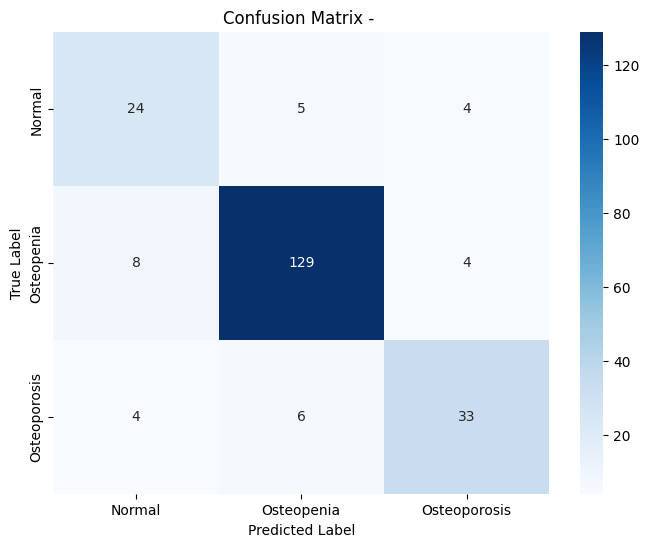

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
)
# Convert to numpy arrays
all_labels_np = np.array(all_labels)
all_preds_np = np.array(all_preds)
all_probs_np = np.array(all_probs)

cm = confusion_matrix(all_labels_np, all_preds_np)
class_names = ["Normal", "Osteopenia", "Osteoporosis"]

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names,
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title(f"Confusion Matrix - ")


In [55]:
test_f1 = f1_score(all_labels_np, all_preds_np, average="macro")
test_precision = precision_score(all_labels_np, all_preds_np, average="macro")
test_recall = recall_score(all_labels_np, all_preds_np, average="macro")
all_labels_one_hot = np.eye(wandb.config.NUM_CLASSES)[all_labels_np]
test_auc = roc_auc_score(
    all_labels_one_hot, all_probs_np, average="macro", multi_class="ovr"
)


In [56]:
auc_str = f"{test_auc:.4f}"
print(
    f"[Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, "
    f"F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, AUC: {auc_str}"
)

[Test Loss: 0.5360, Test Accuracy: 0.8571, F1: 0.7998, Precision: 0.7977, Recall: 0.8032, AUC: 0.9228


In [1]:
import pandas as pd

# Load the copied Excel file
excel_path = r"c:\Users\e0l07sq\Desktop\rnd\osteoporosis_project\data\test_metabolic\patient_details.csv"
excel_output_path = r"c:\Users\e0l07sq\Desktop\rnd\osteoporosis_project\data\test_metabolic\patient_details_with_probs_output.csv"
df = pd.read_csv(excel_path)

# Ensure the DataFrame has the necessary structure
if 'probs' not in df.columns:
    df['probs_class_0'] = None
    df['probs_class_1'] = None
    df['probs_class_2'] = None

df_merged = df.reset_index().merge(df_pred, left_on='Patient Id', right_on='path')
df_merged[['probs_class_0', 'probs_class_1', 'probs_class_2']] = pd.DataFrame(df_merged['probs'].tolist(), index=df_merged.index)


df_merged.to_csv(excel_output_path, index=False)

# Save the updated DataFrame back to the Excel file
print(f"Updated Excel file saved at: {excel_output_path}")

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\e0l07sq\\Desktop\\rnd\\osteoporosis_project\\data\\test_metabolic\\patient_details.csv'

In [80]:
df_merged

,level_0,index,S.No,Patient Id,Joint Pain:,Gender,Age,Menopause Age,height (meter),Weight (KG),...,Obesity,Diagnosis,probs_class_0,probs_class_1,probs_class_2,labels,preds,probs,path,leg_tag
0,0,0,1,OP1,yes,male,65,NaN,1.64592,65,...,normal weight,osteopenia,0.101367,0.684348,0.214285,1,1,"[0.10136694, 0.6843479, 0.21428512]",OP1,both
1,1,1,2,OP2,yes,female,54,46.0,1.67640,78,...,over weight,osteopenia,0.001702,0.996945,0.001353,1,1,"[0.001701962, 0.99694484, 0.0013532082]",OP2,both
2,2,2,3,OP3,yes,female,49,43.0,1.37160,59,...,obesity,osteopenia,0.000405,0.999442,0.000153,1,1,"[0.00040527835, 0.9994418, 0.00015295374]",OP3,both
3,3,3,4,OP4,yes,female,57,40.0,1.52400,72,...,obesity,osteopenia,0.025973,0.953351,0.020677,1,1,"[0.025972787, 0.9533506, 0.020676639]",OP4,both
4,4,4,5,OP5,yes,female,40,NaN,1.49352,54,...,normal weight,osteopenia,0.000902,0.998668,0.000430,1,1,"[0.0009018577, 0.99866784, 0.00043034228]",OP5,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
212,212,233,234,OP150,yes,female,47,41.0,1.48000,78,...,obesity,osteopenia,0.174553,0.590293,0.235154,1,1,"[0.17455328, 0.5902926, 0.23515415]",OP150,right
213,213,234,235,OP151,yes,male,54,NaN,1.69000,68,...,normal weight,osteopenia,0.002016,0.997221,0.000763,1,1,"[0.002015747, 0.99722075, 0.0007634979]",OP151,right
214,214,235,236,OP152,yes,female,56,NaN,1.54000,80,...,obesity,osteopenia,0.023525,0.957102,0.019373,1,1,"[0.023524877, 0.95710236, 0.019372767]",OP152,right
215,215,237,238,OP153,yes,male,49,NaN,1.67000,88,...,obesity,osteopenia,0.003260,0.995505,0.001235,1,1,"[0.003259726, 0.9955052, 0.0012349997]",OP153,right
